# Analyse mit Lime (Local Interpretable Model-Agnostic Explanations)
LIME ist dafür da, eine einzelne Entscheidung des Systems lokal zu analysieren. Es ist Modell-Agnostisch und nutzt ein Surrogate Model (Ersatzmodell).

Deswegen habe ich bestimmte Bilder herausgesucht, welche ich analysieren möchte. Ziel ist es herauszufinden, welche Faktoren zu einer Entscheidung des Modells führen können.

### Laden des Modells und der Pakete

In [ ]:
import sys
sys.path.append('..')

from src.models.modelManager import ModelManager

model_manager = ModelManager()
model = model_manager.load_model() 

from src.config import *
from src.visualization.visualize import visualize_detections, load_image_from_url, show_grid

from lime import lime_image



⬇ Lade Modell: football-ball-detection-rejhg/4
  (Verwendet Cache falls bereits heruntergeladen)


✓ Modell geladen


### Laden der Bilder

In [5]:
# Laden der Gesamten Bilder 
total_images = list(DATASET_PATH.rglob("*.jpg"))
images_length = len(total_images)
print(images_length)

4948


### Selektion der Bilder
- Es ist natürlich zeitlich unmöglich alle Bilder des Datensatzes zu analysieren. Deswegen beschränke ich mich auf bestimmte Bilder, welche interessant wirken
- Zusätzlich schaue ich, dass ich von den vier Kategorien mindestens eins dabei habe
    - True Positive
    - False Positive (dürften relativ schwer zu finden sein)
    - True Negative 
    - False Negative
--> wobei das Modell natürlich nicht einfach nur einen Binärwert, sondern eine Confidence zurückgibt.

Weil das Modell eine hohe Precision (97.4%) aber einen vergleichsweise geringen Recall (78%) besitzt sind vor allem auch die FN interessant.

In [39]:
IMAGES_INDICES = [4298, 1390, 362, 3029, 4247, 726, 4257, 4859, 1288] 

# Verdeckt False Positive

✓ Verwendete Indizes: [4298, 1390, 362, 3029, 4247, 726, 4257, 4859, 1288]


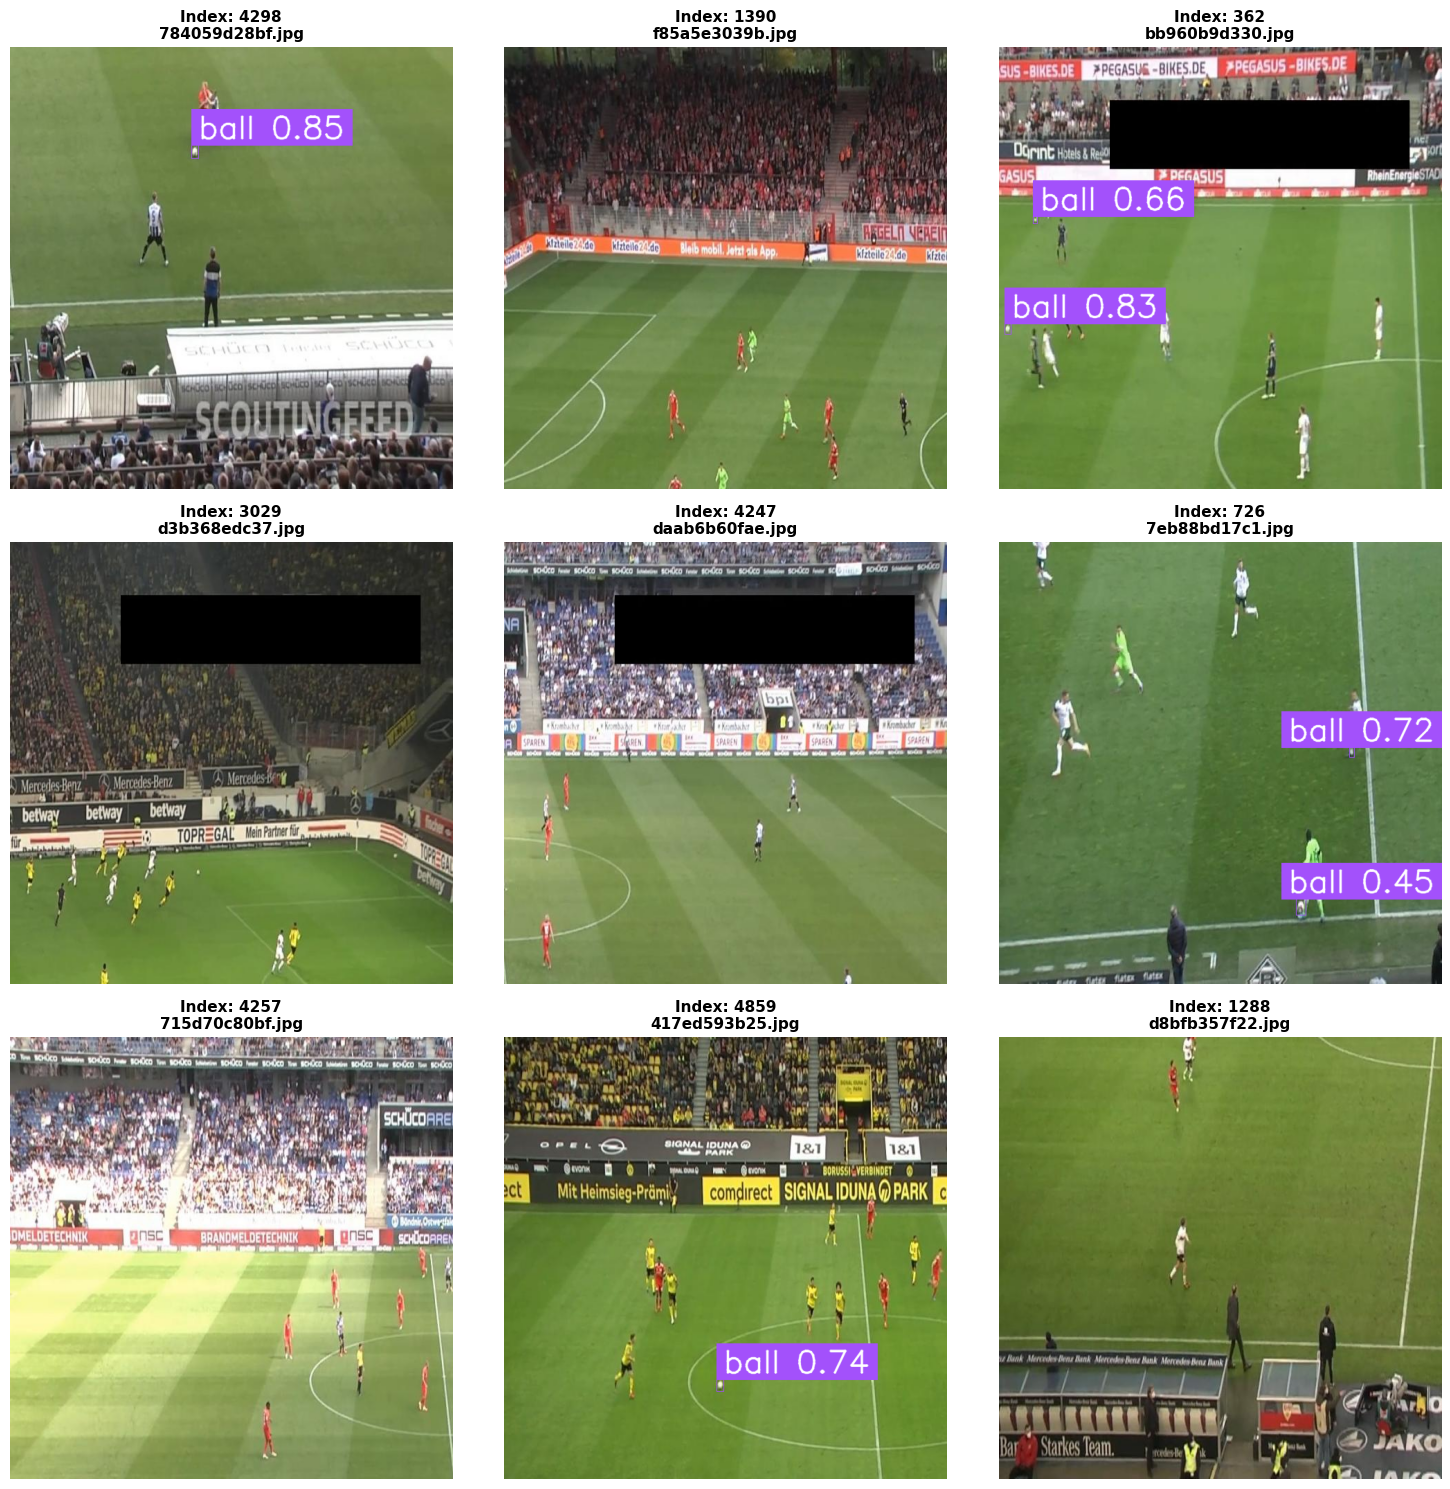

In [40]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# --- DEINE KONFIGURATION ---
# Hier Indizes eintragen, die du fest sehen willst (z.B. [402, 12, 99]).
# Leer lassen [], um 9 zufällige zu bekommen.
MANUAL_INDICES = [4298, 1390, 362, 3029, 4247, 726, 4257, 4859, 1288] 
# ---------------------------

def show_grid(all_images_list, model_manager, fixed_indices):
    rows, cols = 3, 3
    num_slots = rows * cols
    
    # 1. Auswahl der Indizes (Mix aus Manuell + Zufall)
    # Erst die manuellen nehmen (soweit vorhanden)
    current_indices = [i for i in fixed_indices if i < len(all_images_list)]
    
    # Den Rest zufällig auffüllen, ohne Dopplungen
    needed = num_slots - len(current_indices)
    if needed > 0:
        # Wähle aus allen möglichen Indizes, außer denen, die wir schon haben
        available_pool = list(set(range(len(all_images_list))) - set(current_indices))
        random_picks = random.sample(available_pool, needed)
        current_indices.extend(random_picks)
    
    # Indizes auf 9 begrenzen, falls man mehr als 9 manuelle eingetragen hat
    current_indices = current_indices[:num_slots]

    print(f"✓ Verwendete Indizes: {current_indices}")

    # 2. Plotten
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()

    for i, idx in enumerate(current_indices):
        ax = axes[i]
        img_path = all_images_list[idx]
        
        try:
            # Laden & Inference
            img = Image.open(img_path)
            results = model_manager.infer(img)
            
            # Deine Funktion zur Visualisierung nutzen
            annotated = visualize_detections(
                img, 
                results, 
                show_confidence=True, 
                labels_on_image=True
            )
            
            ax.imshow(annotated)
            # WICHTIG: Der Index steht fett im Titel
            ax.set_title(f"Index: {idx}\n{img_path.name[-15:]}", fontsize=11, fontweight='bold')
            ax.axis('off')
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Fehler:\n{e}", ha='center', color='red')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Funktionsaufruf
show_grid(total_images, model_manager, MANUAL_INDICES)

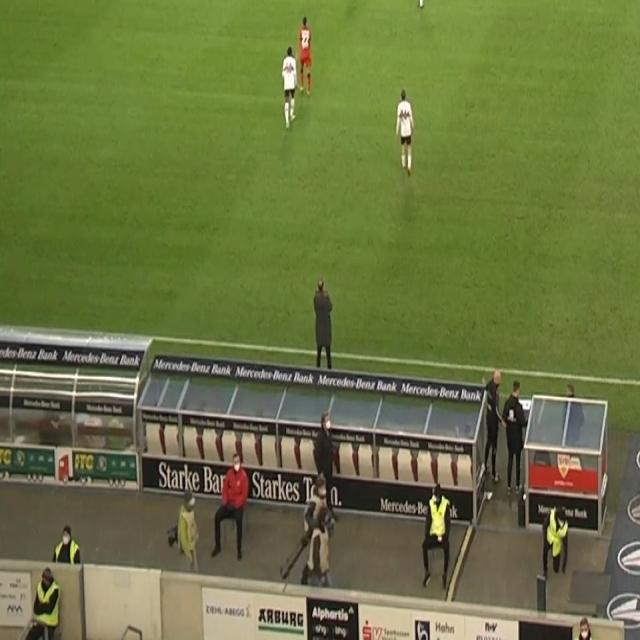

In [29]:
img_path = total_images[1171]
        
            # Laden & Inference
img = Image.open(img_path)
img

[WindowsPath('c:/Users/HP/OneDrive - Duale Hochschule Baden-Württemberg Stuttgart/StudiumGoodNotes/XAI/Computer-Vision_Soccer/notebooks/../data/football-ball-detection-4/train/images/2e57b9_0_mp4-0073_jpg.rf.be8adffee9a2afbd9f01223e583bf6dd.jpg'), WindowsPath('c:/Users/HP/OneDrive - Duale Hochschule Baden-Württemberg Stuttgart/StudiumGoodNotes/XAI/Computer-Vision_Soccer/notebooks/../data/football-ball-detection-4/train/images/40cd38_0_mp4-0061_jpg.rf.9462c1277982db0f672d24510d5be130.jpg'), WindowsPath('c:/Users/HP/OneDrive - Duale Hochschule Baden-Württemberg Stuttgart/StudiumGoodNotes/XAI/Computer-Vision_Soccer/notebooks/../data/football-ball-detection-4/train/images/a9f16c_0_mp4-0046_jpg.rf.56724764702af165e9e7055a6a43f097.jpg'), WindowsPath('c:/Users/HP/OneDrive - Duale Hochschule Baden-Württemberg Stuttgart/StudiumGoodNotes/XAI/Computer-Vision_Soccer/notebooks/../data/football-ball-detection-4/train/images/538438_0_mp4-0035_jpg.rf.87eb06efddd86e6ad5b408742f0781a2.jpg'), WindowsPath

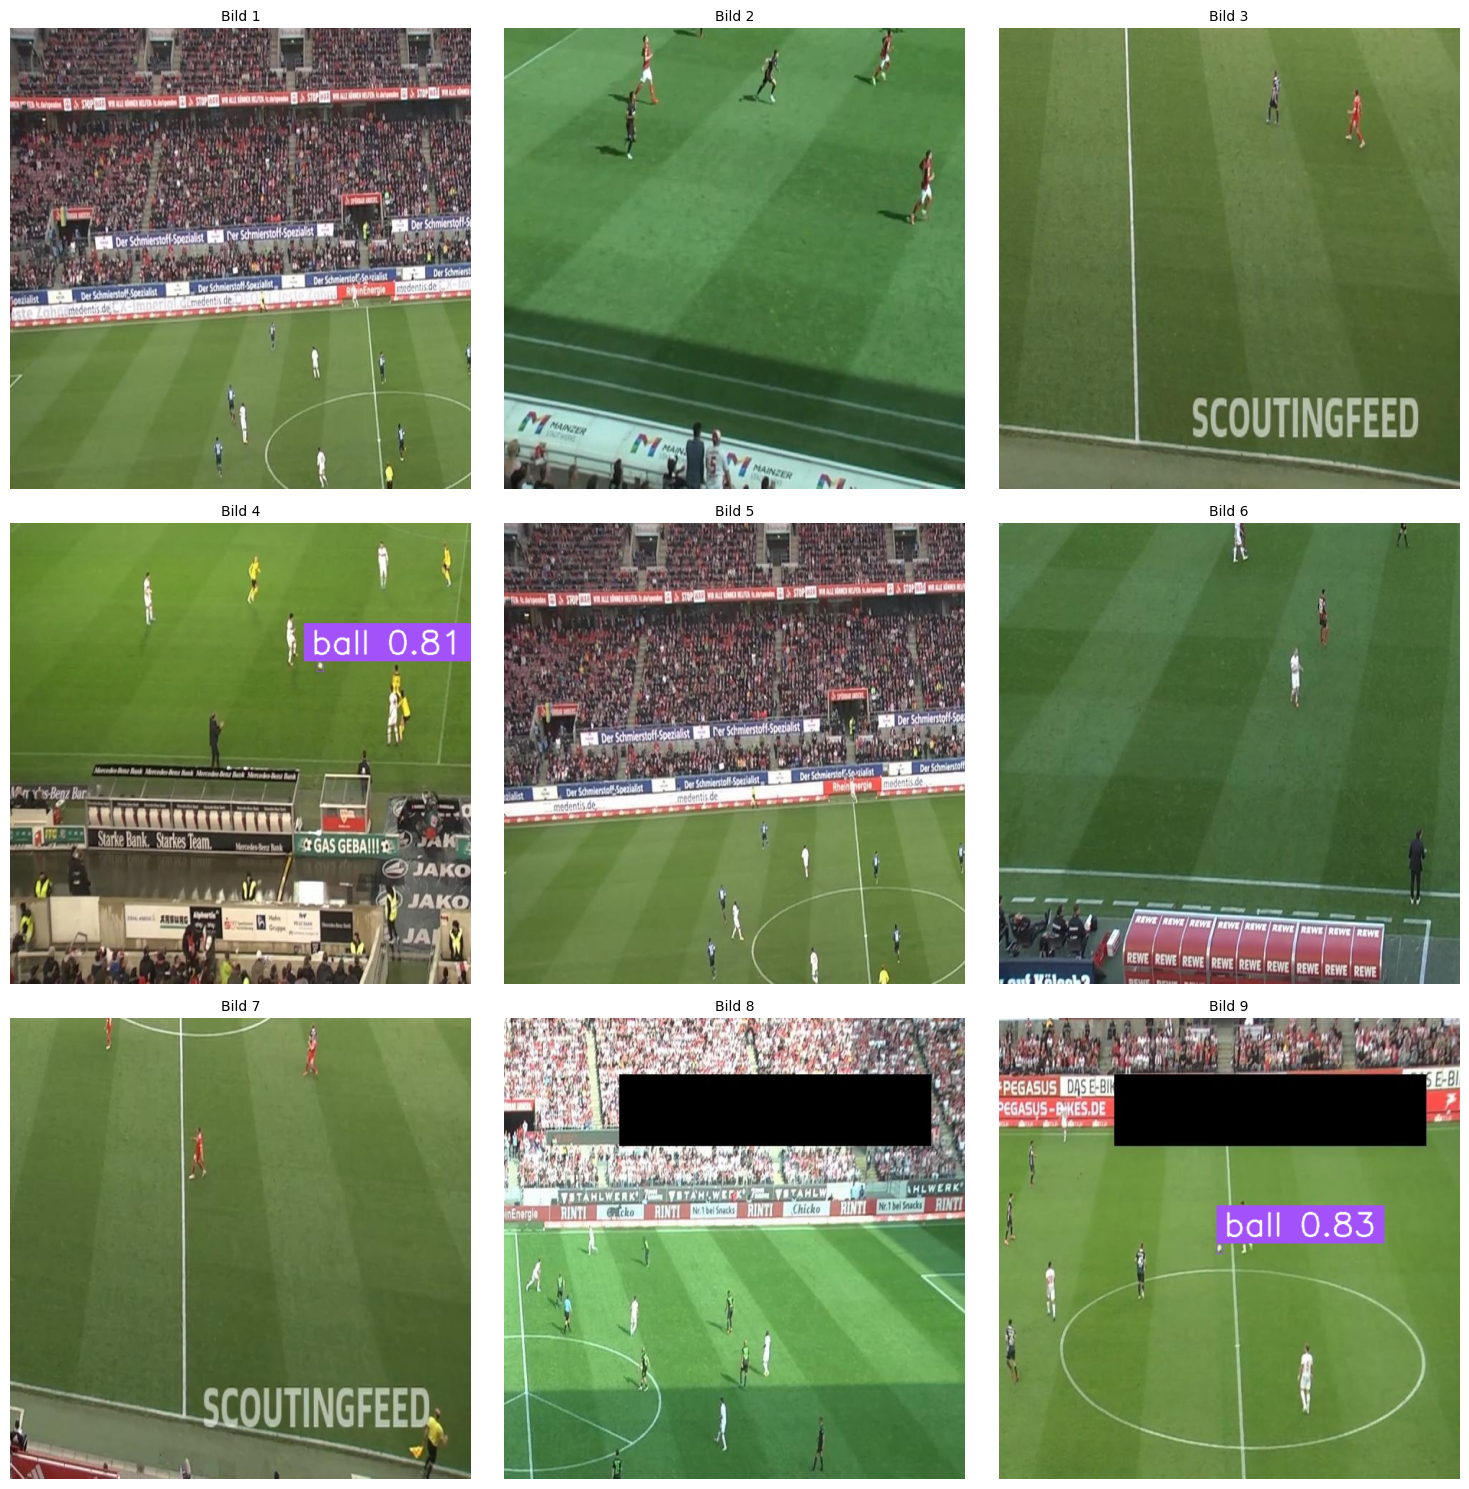

In [9]:
import random
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

def plot_random_matrix(image_list, model_manager, rows=3, cols=3):
    # Zufällige Auswahl von n Bildern
    num_images = rows * cols
    selected_paths = random.sample(image_list, num_images)
    print(selected_paths)
    
    # Plot initialisieren
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten() # Flachklopfen für einfache Iteration
    
    print(f"Starte Inference für {num_images} Bilder...")

    for i, img_path in enumerate(selected_paths):
        ax = axes[i]
        
        try:
            # 1. Bild laden
            image = Image.open(img_path)
            
            # 2. Inference durchführen (Dein Code)
            results = model_manager.infer(image)
            
            # 3. Deine Visualisierungsfunktion nutzen
            # Hinweis: visualize_detections gibt laut deinem Code das Bild zurück
            annotated_image = visualize_detections(
                image, 
                results, 
                show_confidence=True, 
                labels_on_image=True
            )
            
            # 4. Anzeigen
            ax.imshow(annotated_image)
            ax.axis('off') # Achsen ausblenden
            ax.set_title(f"Bild {i+1}", fontsize=10)
            
        except Exception as e:
            print(f"Fehler bei Bild {img_path.name}: {e}")
            ax.text(0.5, 0.5, "Error", ha='center', va='center')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Funktionsaufruf
plot_random_matrix(total_images, model_manager)